# Guidelines

In [1]:
# Etude de faisabilité d'un moteur de classification d'articles basé sur une image et une description 
# pour l'automatisation de l'attribution de la catégorie de l'article,

# 1- Prétraitement des images et des descriptions des produits,
# 2- Une réduction de dimension,
# 3- Puis un clustering:
# Les résultats du clustering -> représentation en deux dimensions à déterminer, illustre que les caractéristiques 
# extraites permettent de regrouper des produits de même catégorie,

# 4- Représentation graphique 
# Attention, Linda n’a pas besoin d’un moteur de classification à ce stade, mais bien d’une étude de faisabilité !

# Extraire les features : SIFT / ORB / SURF,
# CNN Transfer Learning peut être utilisé en complément 

# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import re
import math
import warnings
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import datetime
import nltk
import gensim
import pyLDAvis 
import plotly.express as px
from pyLDAvis import sklearn
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from datetime import datetime
from collections import defaultdict, Counter
from folium import IFrame
from folium.plugins import HeatMap
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_selector
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, QuantileTransformer, RobustScaler, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.impute import SimpleImputer
from sklearn.metrics.cluster import adjusted_rand_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.classify import NaiveBayesClassifier
from PIL import Image, ImageOps, ImageFilter
from scipy.sparse import coo_matrix, csr_matrix 
from yellowbrick.cluster import KElbowVisualizer
from geopy.geocoders import Nominatim
from mpl_toolkits.mplot3d import Axes3D


#
from P6_04_utils import *
#
pd.options.mode.chained_assignment = None  # default='warn'
#
%matplotlib inline
#
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', 100)
#
warnings.filterwarnings('ignore')
# Setting theme
sns.set_theme(style="white")
#
#nltk.download('wordnet')
#
#%reload_ext pycodestyle_magic
#%flake8_on
#%flake8_off

C:\Users\romai\anaconda3\lib\site-packages\h5py\__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


In [2]:
# Check .csv file size
files_list = [r"./data/flipkart_com-ecommerce_sample_1050.csv"]

for file in files_list:
    print(file + ": " + str(os.stat(file).st_size / 2**30) + ' Go')


./data/flipkart_com-ecommerce_sample_1050.csv: 0.0015896949917078018 Go


# Download 

In [3]:
# Import and convert .csv files into pandas dataframes
df = pd.read_csv("./data/flipkart_com-ecommerce_sample_1050.csv",
                 sep=",",
                 encoding="utf-8")


# Data

In [4]:
info(df)
df.head()

15 columns
1050 rows
Rate of missing values in df : 2.165079365079365 %



uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                                                                           product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...   
1           http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2  http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   
3  http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt...   
4  http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v...   

                                                      product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                                                                                 product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   
3  BDSEJT9UQWHDUBH4        2699.0            1299.0   
4  BDSEJTHNGWVGWWQU        2599.0             698.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   
3  d4684dcdc759dd9cdf41504698d737d8.jpg                    False   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...   
4  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                                                                                product_specifications  
0  {"product_specification"=>[{"k

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [6]:
df.describe(include='all')

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     7e3d8e737aec8f1eca019302593c732e  2015-12-01 12:40:44 +0000   
freq                                   1                        150   
mean                                 NaN                        NaN   
std                                  NaN                        NaN   
min                                  NaN                        NaN   
25%                                  NaN                        NaN   
50%                                  NaN                        NaN   
75%                                  NaN                        NaN   
max                                  NaN                        NaN   

                                                                                                product_url  \
count                                                                                                  1050   
unique                                                                                                 1050   
top     http://www.flipkart.com/crystle-crstl-pink-crystle01-usb-led-light/p/itmedhfcbv6kykhd?pid=USGEDH...   
freq                                                                                                      1   
mean                                                                                                    NaN   
std                                                                                                     NaN   
min                                                                                                     NaN   
25%                                                                                                     NaN   
50%                                                                                                     NaN   
75%                                                                                                     NaN   
max                                                                                                     NaN   

                                                   product_name  \
count                                                      1050   
unique                                                     1050   
top     Kool Kidz DMK-011-PK 01 Analog Watch  - For Boys, Girls   
freq                                                          1   
mean                                                        NaN   
std                                                         NaN   
min                                                         NaN   
25%                                                         NaN   
50%                                                         NaN   
75%                                                         NaN   
max                                                         NaN   

                                                product_category_tree  \
count                                                            1050   
unique                                                            642   
top     ["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]   
freq                                                               56   
mean                                                              NaN   
std                                                               NaN   
min                                                               NaN   
25%                                                               NaN   
50%                                                               NaN   
75%                                                               NaN   
max                                                               NaN   

                     pid   retail_price  discounted_price  \
count               1050    1049.000000       1049.000000   
unique              1050            NaN    

<AxesSubplot:>

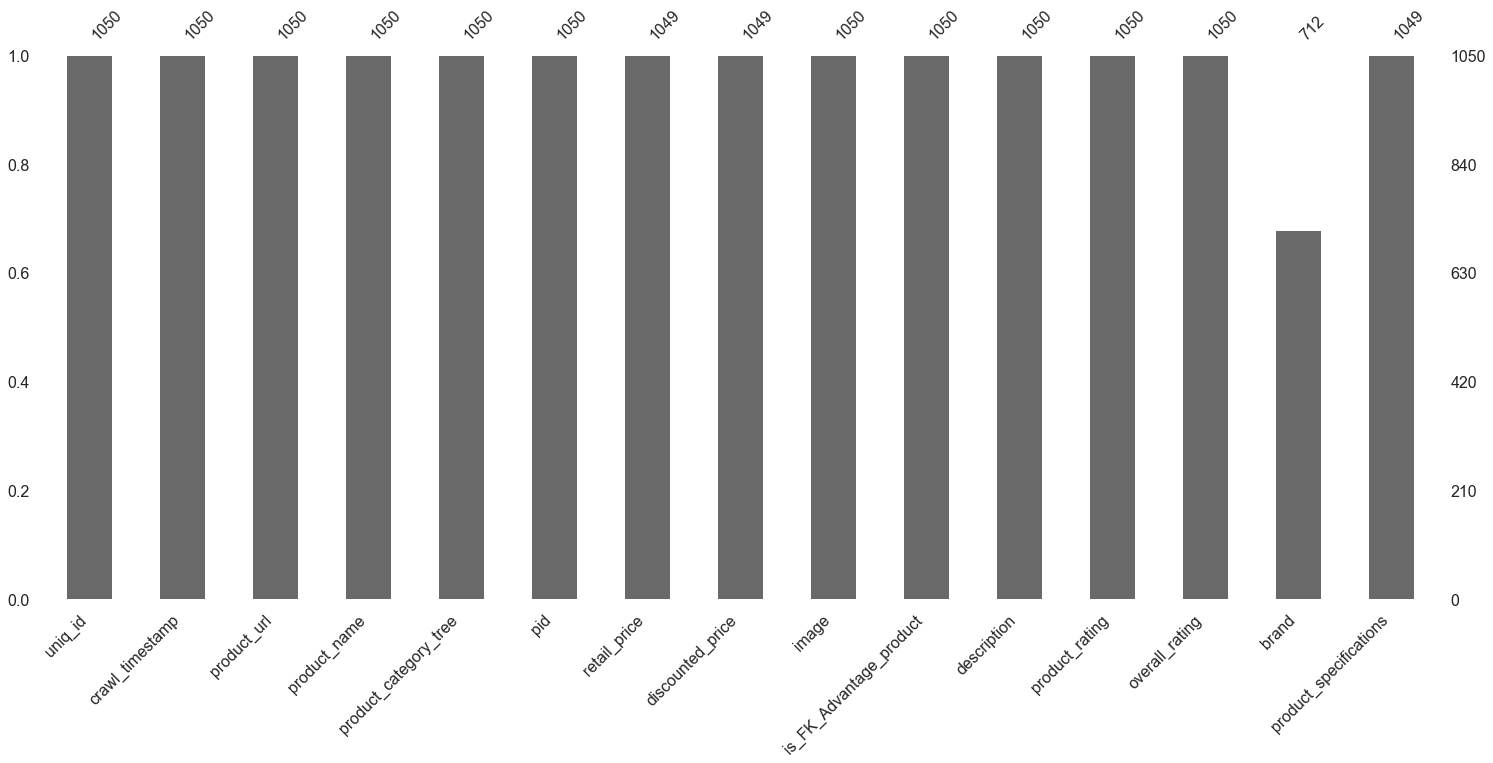

In [7]:
msno.bar(df)

# df_text

In [13]:
# Select relevant columns for next treatments
df_text = df[['product_name', 
             'product_category_tree', 
             'description']]

# Overview
info(df_text)
df_text.head()

3 columns
1050 rows
Rate of missing values in df : 0.0 %



product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                                                                                 product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...   

                                                                                           description  
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...  
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...  
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...  
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...  
4  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...

In [14]:
df_text.description[666]

'Portia Polka Print Trendy Cap - Buy Multicolor Portia Polka Print Trendy Cap For Only Rs. 900 Online in India. Shop Online For Apparels. Huge Collection of Branded Clothes Only at Flipkart.com'

## Product category treatment

In [10]:
#
df_text = prepare_category_column_function(df_text, "product_category_tree", 3)

#
df_text = select_category_depth_function(df_text, 1)

# Overview
info(df_text)
df_text.head()

Unique categories at level 1: 7

4 columns
1050 rows
Rate of missing values in df : 0.0 %



product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                                                                                 product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...   
4  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...   

   product_category  
0  Home Furnishing   
1        Baby Care   
2        Baby Care   
3  Home Furnishing   
4  Home Furnishing

<AxesSubplot:>

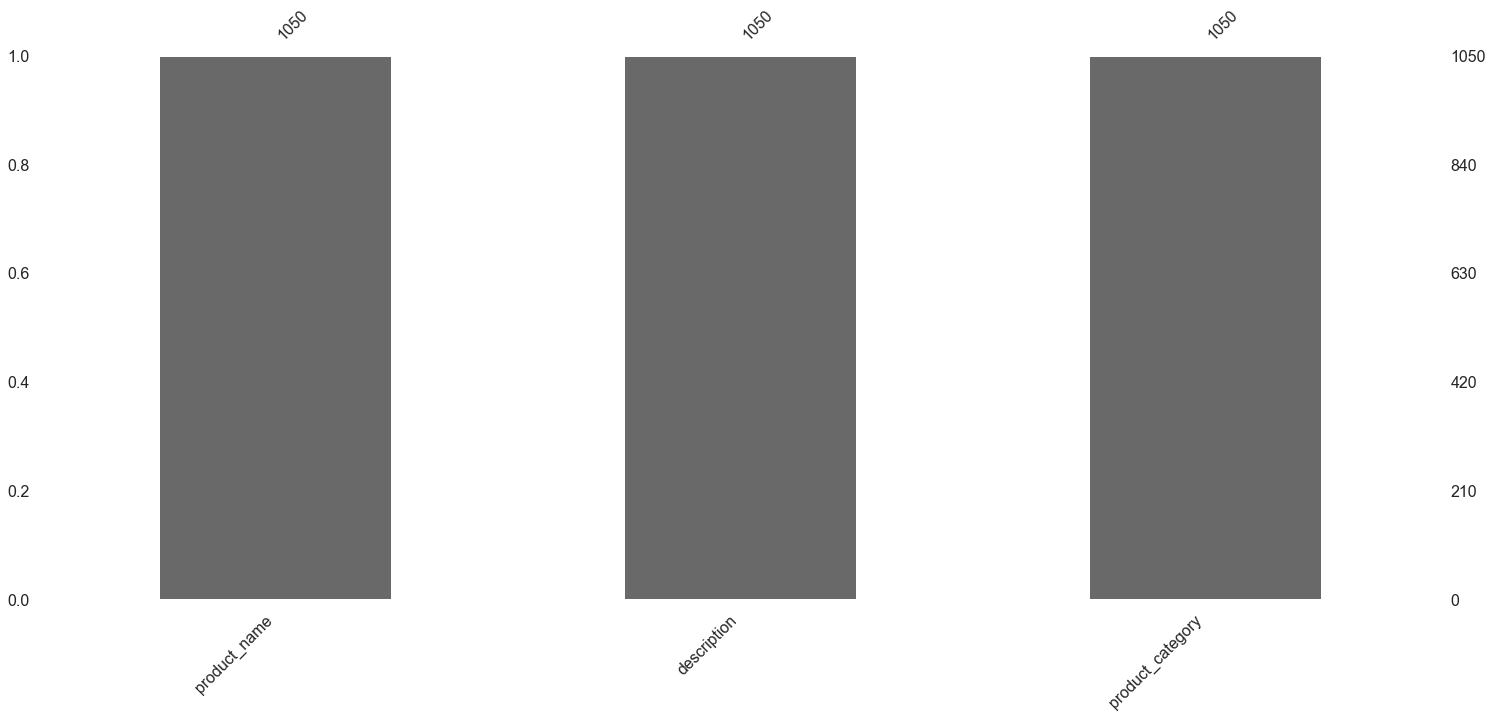

In [11]:
df_text = df_text[['product_name','description','product_category']]

msno.bar(df_text)

In [12]:
print("Unique categories: " + str(df_text.product_category.unique()))
print(len(df_text.product_category.unique()))

Unique categories: ['Home Furnishing ' 'Baby Care ' 'Watches ' 'Home Decor & Festive Needs '
 'Kitchen & Dining ' 'Beauty and Personal Care ' 'Computers ']
7


## Pre-processing

In [13]:
# - Créer des paires de document (article, highlights)
# - Suppression de la ponctuation
# - Séparation en token en minuscules
# - Suppression des stopwords pour les articles
# - Calcul des fréquences et tf-idf sur les deux types de documents
# - Enregistrement du nouveau jeu de données d’entraînement pour usage ultérieur

In [14]:
# normalize_text_column_function() is defined in utils.py
df_text = preprocessing_description_function(df_text, 
                                             'description', 
                                             stopwords.words('english'))
                                           
df_text.head()

product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

   product_category  \
0  Home Furnishing    
1        Baby Care    
2        Baby Care    
3  Home Furnishing    
4  Home Furnishing    

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...   
4  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...   

                                                                        description_normalize_stemming  \
0  key featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest mult...   
1  specif sathiya cotton bath towel bath towel red yellow blue bath towel featur machin washabl ye ...   
2  key featur eurospa cotton terri face towel set size small height inch gsm eurospa cotton terri f...   
3  key featur santosh royal fashion cotton print king size doubl bedsheet royal bedsheet perfact we...   
4  key featur jaipur print cotton floral king size doubl bedsheet cotton jaipur print cotton floral...   

                                                                         description_normalize_lemming  
0  key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance p...  
1  specification sathiyas cotton bath towel bath towel red yellow blue bath towel feature machine w...  
2  key feature eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry ...  
3  key feature santosh royal fashion cotton printed king sized double bedsheet royal bedsheet perfa...  
4  key feature jaipur print cotton floral king sized double bedsheet cotton jaipur print cotton flo...

## Sandbox (LDA)

In [15]:
#
params = {'min_df' : 10,
          'max_df' : 1.0,
          'norm': 'l2',
          'use_idf' : True}

# lda_function is defined in utils.py
lda_output  = lda_function(df_text, 
                             'description_normalize_lemming', 
                             "", 
                             7,
                             params)


(description_normalize_lemming):

Top 10 words for Topic #0
skin laptop shape pad mouse print warranty hair set combo

Top 10 words for Topic #1
baby cotton girl detail fabric dress boy sleeve neck pack

Top 10 words for Topic #2
com flipkart shipping genuine cash delivery buy free product guarantee

Top 10 words for Topic #3
cm polyester design eyelet comfort curtain aroma height brown model

Top 10 words for Topic #4
mug ceramic coffee prithish perfect rockmantra gift one safe loved

Top 10 words for Topic #5
sticker vinyl medium large wall paper small store apply surface

Top 10 words for Topic #6
usb warranty adapter light power led laptop flexible charger portable



In [16]:
'''#
lda = lda_output[0]
tf = lda_output[1]
tf_vectorizer = lda_output[2]

#
pyLDAvis.enable_notebook()
panel = sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel'''

"#\nlda = lda_output[0]\ntf = lda_output[1]\ntf_vectorizer = lda_output[2]\n\n#\npyLDAvis.enable_notebook()\npanel = sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')\npanel"

## Sandbox (Word embedding)

### TF-IDF

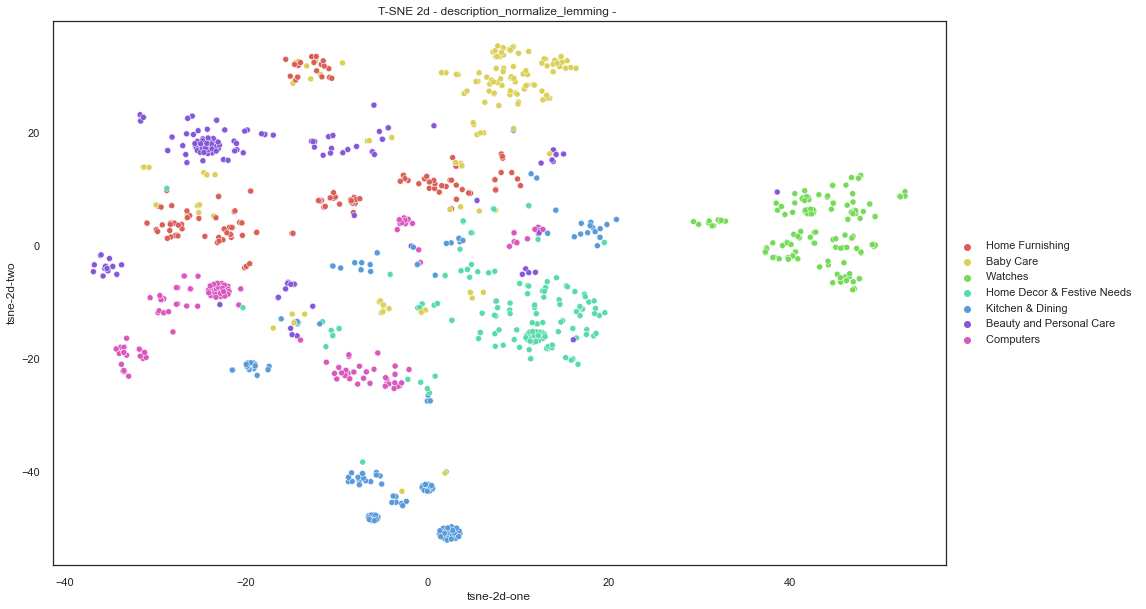

In [17]:
#
params = {'min_df' : .01,
          'max_df' : 0.95,
          #'max_features' : n_features, 
          'stop_words' : "english",
          'use_idf' : True}


# tfidf_function is defined in utils.py
# displays tf-idf with tsne-2d
tfidf_function(df_text, 
               'description_normalize_lemming', 
               "", 
               "product_category",
               params)


### Gensim

In [18]:
df_text.sort_values('product_category').head()

product_name product_category  \
1049                       Uberlyfe Large Vinyl Sticker       Baby Care    
613                 Piyo Piyo Four Stage Waterproof Bib       Baby Care    
612     Cheeky Chompers The Neckerchew - Simple Classic       Baby Care    
977                   FS Mini Klub Baby Girl's Bodysuit       Baby Care    
975   Jacadi paris Baby Boy's Striped Casual Blue Shirt       Baby Care    

                                                                                              description  \
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 online. Uberlyfe Large Vinyl Sticker at best prices ...   
613   Specifications of Piyo Piyo Four Stage Waterproof Bib (Yellow) General Brand Piyo Piyo Loop Type...   
612   Specifications of Cheeky Chompers The Neckerchew - Simple Classic (Sky) General Brand Cheeky Cho...   
977   Key Features of FS Mini Klub Baby Girl's Bodysuit Fabric: Cotton Brand Color: GREEN,Specificatio...   
975   Key Features of Jacadi paris Baby Boy's Striped Casual Blue Shirt Cotton stripped dress shirt,Ja...   

                                                                           description_normalize_stemming  \
1049  buy uberlyf larg vinyl sticker rs onlin uberlyf larg vinyl sticker best price free ship cash del...   
613   specif piyo piyo four stage waterproof bib yellow gener brand piyo piyo loop type velcro materi ...   
612   specif cheeki chomper neckerchew simpl classic sky gener brand cheeki chomper loop type knot but...   
977   key featur fs mini klub babi girl bodysuit fabric cotton brand color green specif fs mini klub b...   
975   key featur jacadi pari babi boy stripe casual blue shirt cotton strip dress shirt jacadi pari ba...   

                                                                            description_normalize_lemming  
1049  buy uberlyfe large vinyl sticker r online uberlyfe large vinyl sticker best price free shipping ...  
613   specification piyo piyo four stage waterproof bib yellow general brand piyo piyo loop type velcr...  
612   specification cheeky chompers neckerchew simple classic sky general brand cheeky chompers loop t...  
977   key feature f mini klub baby girl bodysuit fabric cotton brand color green specification f mini ...  
975   key feature jacadi paris baby boy striped casual blue shirt cotton stripped dress shirt jacadi p...

In [19]:
'''# word_embedding_function is defined in utils.py

# displays tsne-2d
word_embedding_function(df_text.sort_values('product_category'), 
                        'description_normalize_lemming',
                        "",
                        4000)'''  
                          

'# word_embedding_function is defined in utils.py\n\n# displays tsne-2d\nword_embedding_function(df_text.sort_values(\'product_category\'), \n                        \'description_normalize_lemming\',\n                        "",\n                        4000)'

## Classification

In [20]:
#
tfidf_params = {#'min_df' : 2,
                  #'max_df' : 0.95,
                  #'max_features' : n_features, 
                  'stop_words' : "english",
                  'use_idf' : False}


# 
outputs = text_classification_function(df_text, MultinomialNB(), 'description_normalize_lemming', 'product_category', tfidf_params)

Accuracy: 86.66666666666667 %


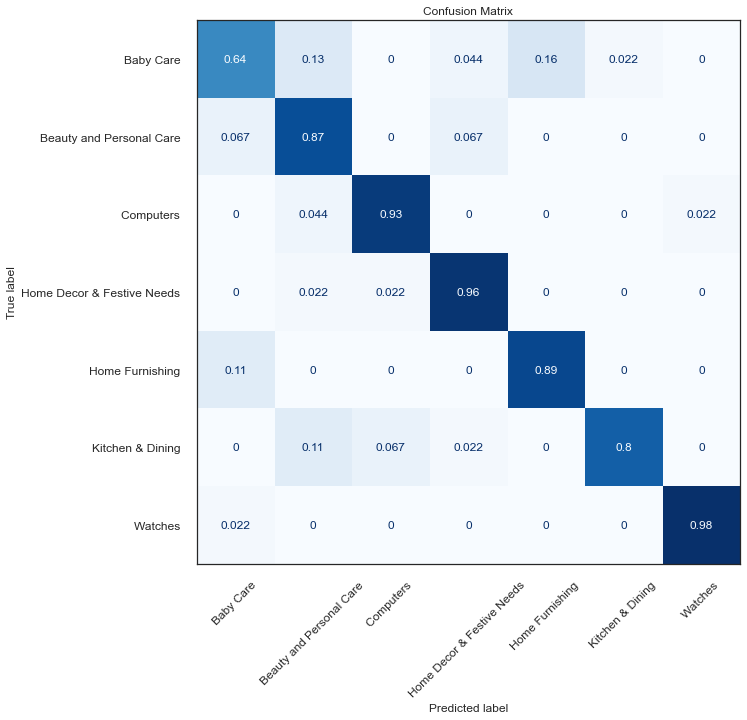

In [21]:
# confusion matrx
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(outputs[0],
                            outputs[1],
                            outputs[2],
                            cmap='Blues',
                            normalize='true',
                            values_format='.2g',
                            ax=ax,
                            colorbar=False)

# parameters
disp.ax_.set_title("Confusion Matrix")
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='x', rotation=45)

plt.show()

## Clustering

In [22]:
# Overview
info(df_text)
df_text.head()

5 columns
1050 rows
Rate of missing values in df : 0.0 %



product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

   product_category  \
0  Home Furnishing    
1        Baby Care    
2        Baby Care    
3  Home Furnishing    
4  Home Furnishing    

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...   
4  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...   

                                                                        description_normalize_stemming  \
0  key featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest mult...   
1  specif sathiya cotton bath towel bath towel red yellow blue bath towel featur machin washabl ye ...   
2  key featur eurospa cotton terri face towel set size small height inch gsm eurospa cotton terri f...   
3  key featur santosh royal fashion cotton print king size doubl bedsheet royal bedsheet perfact we...   
4  key featur jaipur print cotton floral king size doubl bedsheet cotton jaipur print cotton floral...   

                                                                         description_normalize_lemming  
0  key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance p...  
1  specification sathiyas cotton bath towel bath towel red yellow blue bath towel feature machine w...  
2  key feature eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry ...  
3  key feature santosh royal fashion cotton printed king sized double bedsheet royal bedsheet perfa...  
4  key feature jaipur print cotton floral king sized double bedsheet cotton jaipur print cotton flo...

### TFIDF


Elbow method:



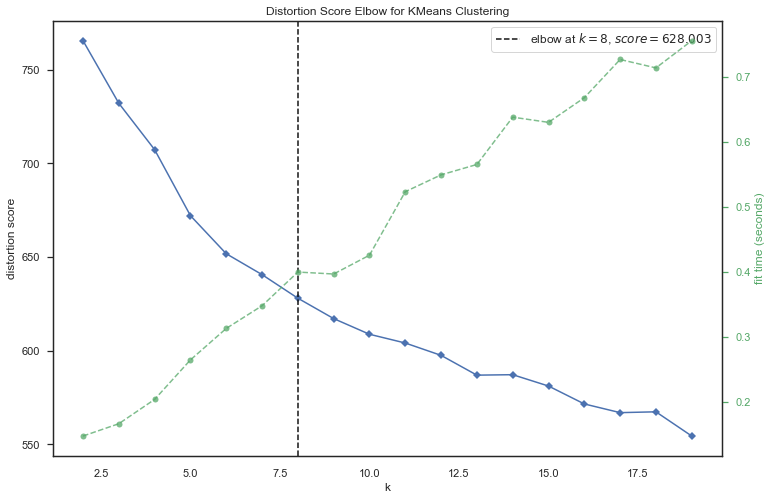

In [23]:
df_text_plot = df_text.copy()

#
tfidf_params = {#'min_df' : 2,
                  #'max_df' : 0.95,
                  #'max_features' : n_features, 
                  'stop_words' : "english",
                  'use_idf' : False}

#
clustering_params = {'n_clusters': 7}

#
clustering_text_tfidf = ClusteringText(df_text_plot,
                                    'description_normalize_stemming',
                                    '', ### (space after word) ###
                                    KMeans,
                                    clustering_params,
                                    20,
                                    tfidf_params)

#
text_vectorized_tfidf = clustering_text_tfidf.find_optimal_clusters_function("tfidf")



#### 2D



PCA:

(PCA) explained variance for 550 components: 0.9627166812314573



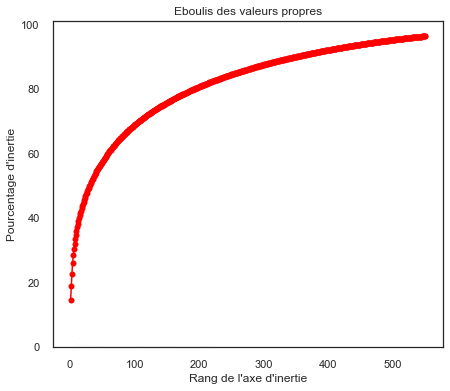



Clustering:



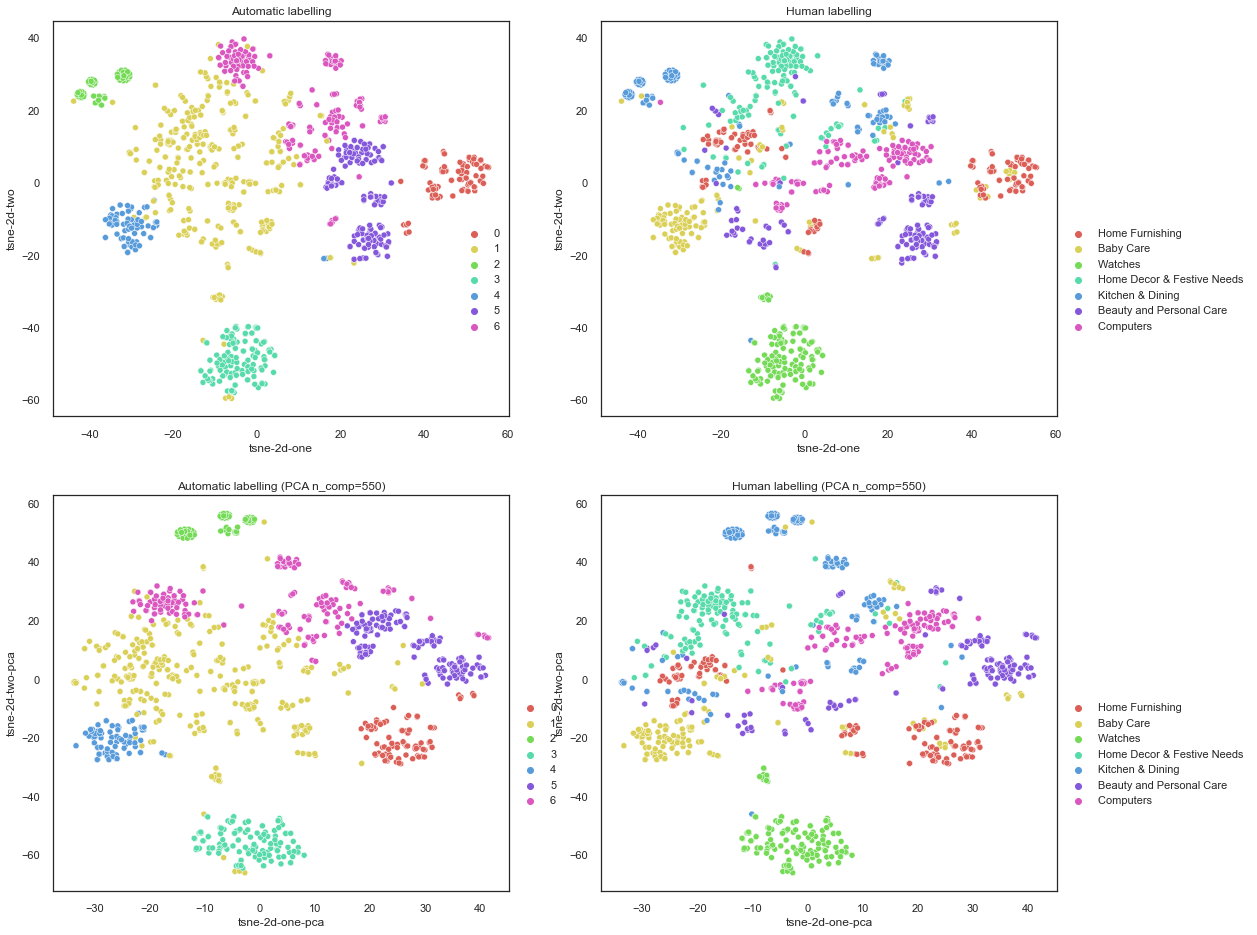


clustering stats:

ARI: 0.2795896204424632
Silhouette: 0.13639960426081135
Clustering fit time: 0.372006

clustering stats after pca:

ARI: 0.2651114013451298
Silhouette: 0.199404520885713
Clustering fit time: 0.195477


In [24]:
#
res_tfidf = clustering_text_tfidf.text_clustering_function(550)

#### 3D

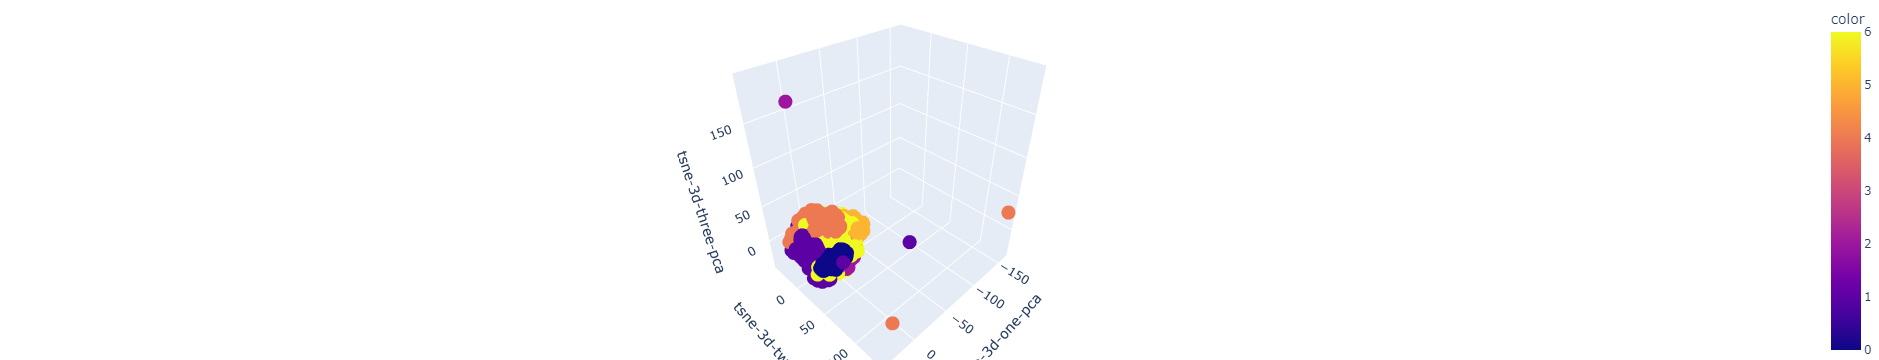

In [25]:
#
clustering_text_tfidf.clustering_3d_function('automatic', True)


#### Confusion matrix

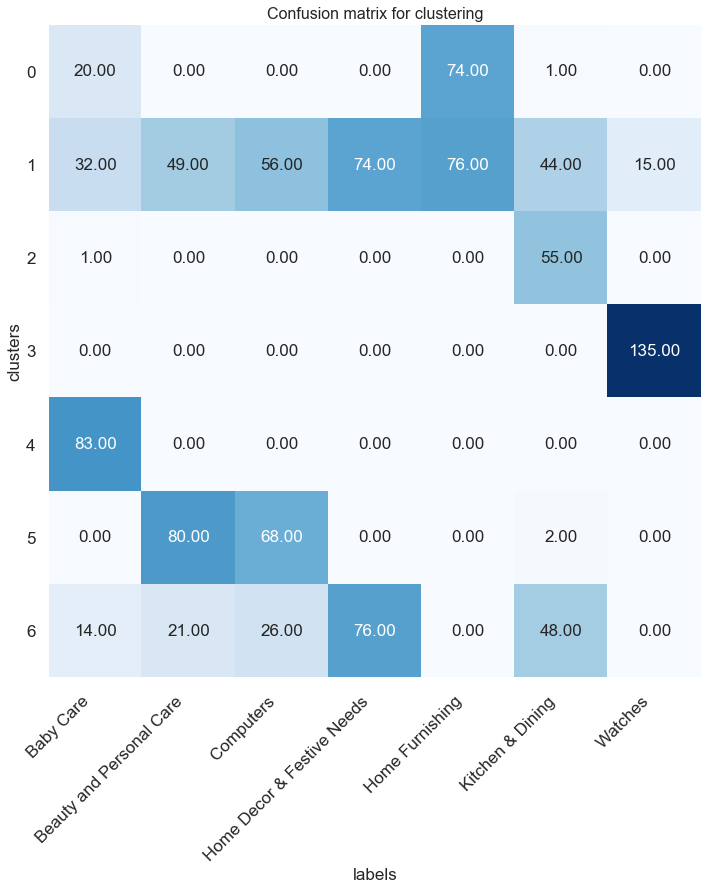

In [26]:
#
plot_confusion_matrix_function(res_tfidf[0], res_tfidf[1], "Confusion matrix for clustering")


### Gensim 

In [27]:
df_text_plot = df_text.copy()

#
tfidf_params = {#'min_df' : 2,
                  #'max_df' : 0.95,
                  #'max_features' : n_features, 
                  'stop_words' : "english",
                  'use_idf' : False}

#
clustering_params = {'n_clusters': 7}


#
clustering_text_gensim = ClusteringText(df_text_plot,
                                    'description_normalize_lemming',
                                    '', ### (space after word) ###
                                    KMeans,
                                    clustering_params,
                                    20,
                                    tfidf_params)

#
text_vectorized_gensim = clustering_text_gensim.find_optimal_clusters_function("gensim")



#### 2D



PCA:

(PCA) explained variance for 14 components: 0.9499920127024645



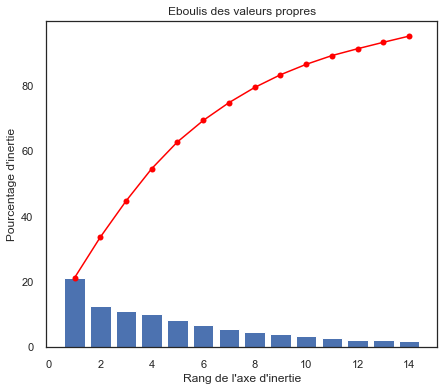



Clustering:



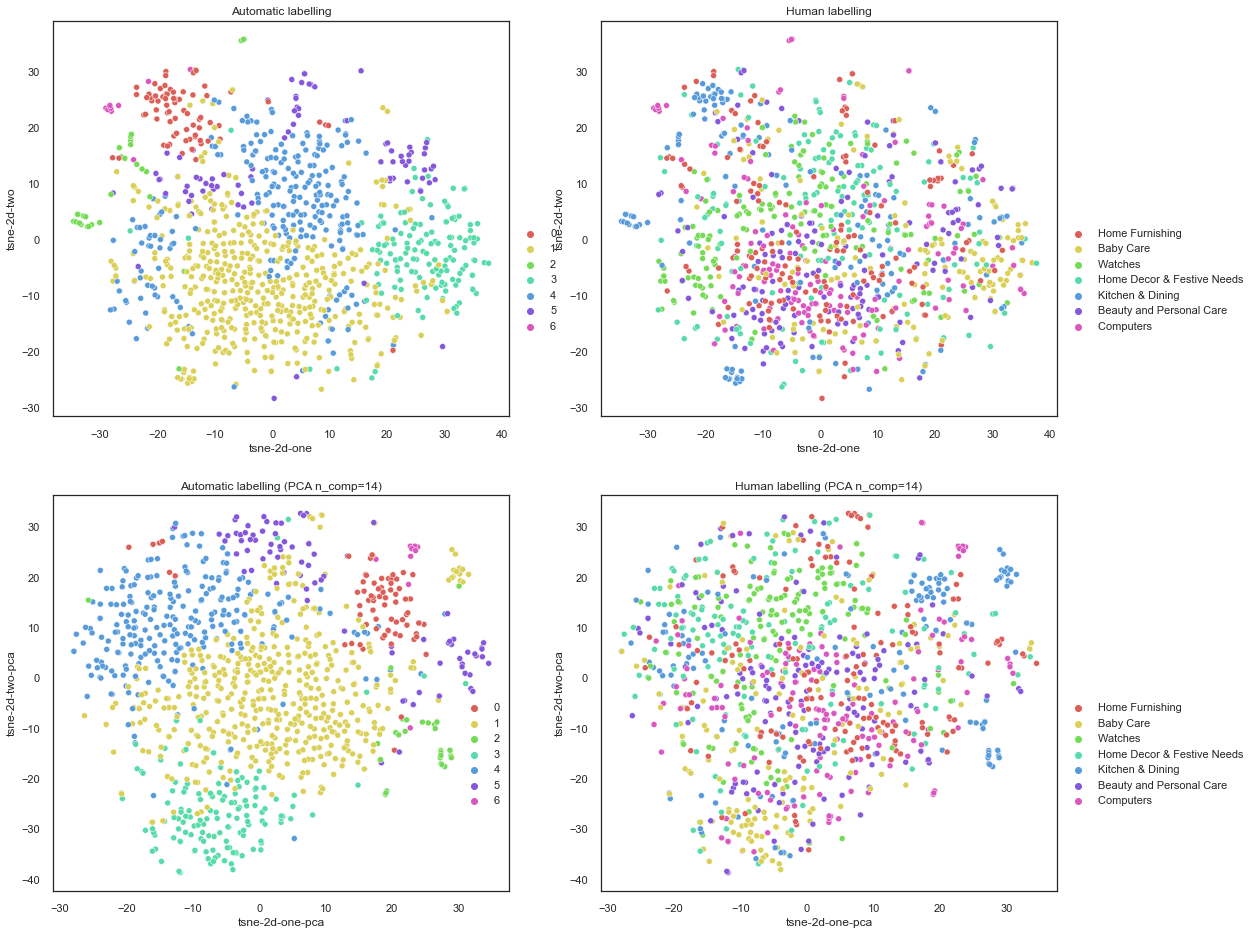


clustering stats:

ARI: 0.04895295014042732
Silhouette: 0.08865115118982411
Clustering fit time: 0.122674

clustering stats after pca:

ARI: 0.04731070452916785
Silhouette: 0.08330560605309102
Clustering fit time: 0.116683


In [28]:
#
res_gensim = clustering_text_gensim.text_clustering_function(14)

#### 3D

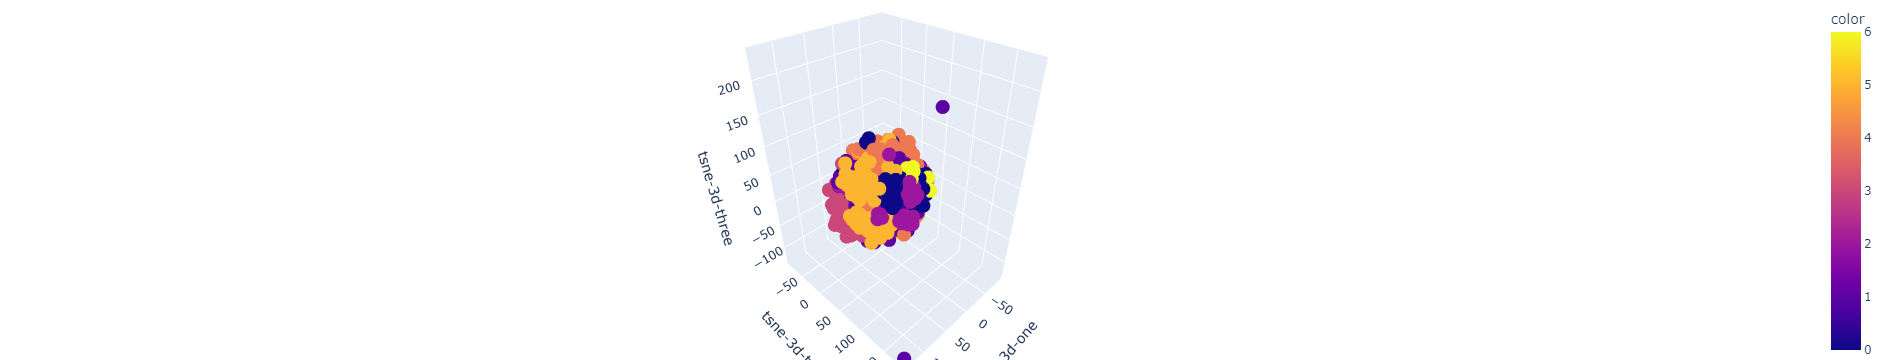

In [29]:
#
clustering_text_gensim.clustering_3d_function('automatic', False)


#### Confusion matrix

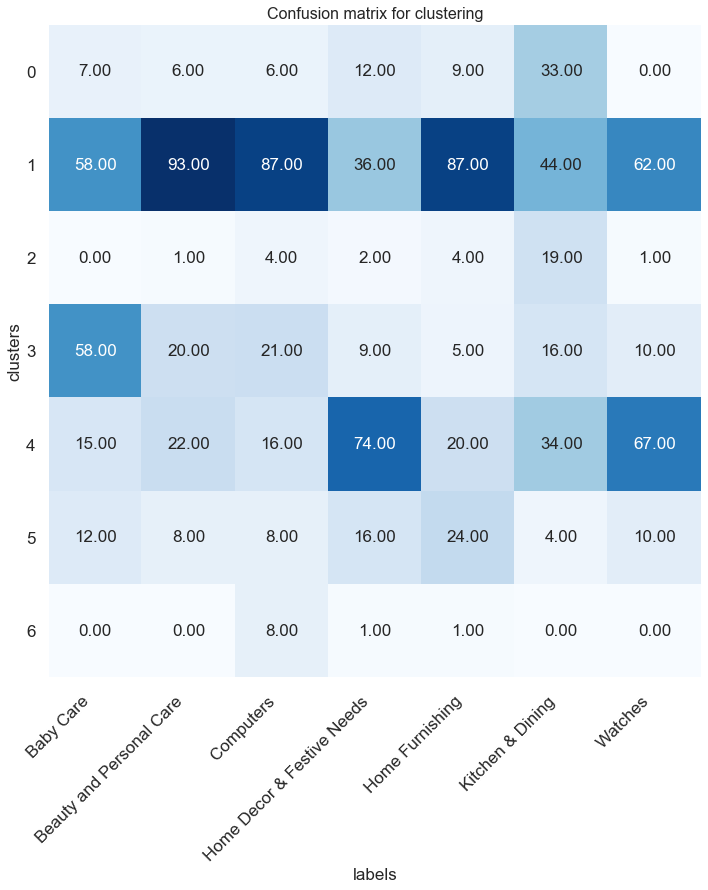

In [30]:
#
plot_confusion_matrix_function(res_gensim[0], res_gensim[1], "Confusion matrix for clustering")

### Stats

In [31]:
# sum_up_table_function is defined in utils.py
df_table_1 = sum_up_table_function('Silhouette', 
                                'descending',
                                tfidf=res_tfidf[3],
                                tfidf_pca=res_tfidf[4],
                                gensim=res_gensim[3],
                                gensim_pca=res_gensim[4]
                               )

#
df_table_1.to_pickle("data/df_table_1.pkt")

df_table_1 = df_table_1.style.highlight_min(color = 'red', axis = 0).highlight_max(color = 'green', axis = 0)
df_table_1

# Export data for further use

In [32]:
# Create a DataFrame with labels and varieties as columns: df
df_export = pd.DataFrame({'text_vectorized_pca_tfidf_numpy': res_tfidf[5].tolist(),
                          'product_catgeory': df_text_plot['product_category'],
                          'product_name': df_text_plot['product_name']}, 
                         index=range(1050))

#
df_export.to_pickle("data/df_export.pkt")

#
output = pd.read_pickle("data/df_export.pkt")
output

text_vectorized_pca_tfidf_numpy  \
0     [-0.39328820017381527, -0.06855124847576416, 0.0503748597066191, -0.038772747574730426, -0.22275...   
1     [-0.41923352015070287, 0.04122570261430237, 0.17563889778768826, -0.011490592059028939, -0.06167...   
2     [-0.35951278198376946, -0.02991632039884139, 0.1626705213808944, -0.018912874091898842, -0.07484...   
3     [-0.43498126689169314, -0.08268525412436892, 0.06054554845741921, -0.19480921265645493, -0.21754...   
4     [-0.39972811722106305, -0.08624820304514738, 0.08246140556013606, -0.18122184908726452, -0.18683...   
...                                                                                                   ...   
1045  [-0.2873784932063822, -0.011298566969161232, -0.011202482022532434, -0.005209732955659415, -0.08...   
1046  [-0.26412172468187545, -0.06617820528381378, -0.056255583416018794, 0.03827341334929434, -0.0997...   
1047  [0.13179042384599868, -0.0990254377821441, -0.14906481231453508, -0.10590457489536764, 0.1199113...   
1048  [0.15055093594290636, -0.11098233429107944, -0.16475431687438108, -0.11983322126065324, 0.131242...   
1049  [0.22910245520885916, -0.1276830802874068, -0.18482166478780415, -0.13689973833116978, 0.1564170...   

      product_catgeory  \
0     Home Furnishing    
1           Baby Care    
2           Baby Care    
3     Home Furnishing    
4     Home Furnishing    
...                ...   
1045        Baby Care    
1046        Baby Care    
1047        Baby Care    
1048        Baby Care    
1049        Baby Care    

                                                           product_name  
0            Elegance Polyester Multicolor Abstract Eyelet Door Curtain  
1                                            Sathiyas Cotton Bath Towel  
2                                   Eurospa Cotton Terry Face Towel Set  
3       SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet  
4                 Jaipur Print Cotton Floral King sized Double Bedsheet  
...                                                                 ...  
1045                     Oren Empower Extra Large Self Adhesive Sticker  
1046                             Wallmantra Large Vinyl Sticker Sticker  
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker  
1048                            Wallmantra Medium Vinyl Sticker Sticker  
1049                                       Uberlyfe Large Vinyl Sticker  

[1050 rows x 3 columns]